In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchsummary import summary
from torch.cuda.amp import autocast, GradScaler

import numpy as np
import gzip
import pickle
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc
import time
import random
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from collections import deque
import pandas as pd


import sys
sys.path.append('..')
# from slp_package.slp_functions import create_merged_game_data_df
from slp_package.input_dataset import InputDataSet
import slp_package.pytorch_functions as slp_pytorch_functions

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using CUDA
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [2]:
source_data = ['ranked','public','mango']

general_features = {
    'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
    'num_players': [2],
    'conclusive': [True],
}
player_features = {
    # 'netplay_code': ['MANG#0'],
    # 'character_name': ['FALCO'],
    # 'character_name': ['FOX', 'FALCO', 'MARTH', 'CAPTAIN_FALCON', 'SHEIK'],
    'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'MARIO', 'PEACH', 'ROY', 'LUIGI', 'YOUNG_LINK', 'DONKEY_KONG', 'PICHU', 'KIRBY'],
    # 'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'PEACH', 'LUIGI', 'DONKEY_KONG'],
    'type_name': ['HUMAN']
    
}
opposing_player_features = {
    # 'character_name': ['MARTH'],
    # 'netplay_code': ['KOD#0', 'ZAIN#0']
    'type_name': ['HUMAN']
}
label_info = {
    'source': ['player'], # Can be 'general', 'player
    # 'feature': ['netplay_code']
    'feature': ['character_name']
}

In [3]:
dataset = InputDataSet(source_data, general_features, player_features, opposing_player_features, label_info)

print(dataset.dataset['labels'].value_counts())
dataset.dataset.head()

/workspace/slp_jaspar/autoencoder/../slp_package/input_dataset.py:95: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  processed_df = pd.concat([player_1_df, player_2_df], ignore_index=True)


FOX               103069
FALCO              90719
MARTH              53728
CAPTAIN_FALCON     38006
SHEIK              27623
PEACH              17438
JIGGLYPUFF         16374
SAMUS               9524
ICE_CLIMBERS        6849
GANONDORF           6655
YOSHI               5725
LUIGI               5230
DR_MARIO            4202
PIKACHU             4096
LINK                2502
NESS                2306
DONKEY_KONG         2026
GAME_AND_WATCH      1967
MEWTWO              1775
MARIO               1713
YOUNG_LINK          1447
ROY                 1272
BOWSER               940
KIRBY                556
PICHU                230
Name: labels, dtype: int64


,stage_name,num_players,conclusive,player_character_name,player_type_name,opposing_player_type_name,player_inputs_np_sub_path,length,labels
0,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\727e819f-8cb3-4c3f-bf0a-ceefa9e41c...,5606,FALCO
1,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\76fe3db5-60de-46bb-8f0d-80d48822a8...,5754,FALCO
2,POKEMON_STADIUM,2,True,MARTH,HUMAN,HUMAN,mango\MARTH\7e6b417f-249d-4629-b6dc-2fe1d95d8f...,6213,MARTH
3,FOUNTAIN_OF_DREAMS,2,True,FOX,HUMAN,HUMAN,mango\FOX\32305eaf-71d8-46e5-a8a1-2c7c890a9baf...,7621,FOX
4,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\a5396c32-6f2c-4b88-8582-f8b875bb55...,7840,FALCO


In [4]:
labels_order =  dataset.number_of_segments_per_game(60,5000)
print(labels_order)
labels_order = labels_order['Label'].values

             Label   Count   Shift
0              FOX  103069  193497
1            FALCO   90717  168117
2            MARTH   53728  106569
3   CAPTAIN_FALCON   38006   70125
4            SHEIK   27623   59145
5            PEACH   17438   39398
6       JIGGLYPUFF   16374   35581
7            SAMUS    9524   23031
8     ICE_CLIMBERS    6849   15620
9        GANONDORF    6655   12805
10           YOSHI    5725   12226
11           LUIGI    5230   11464
12        DR_MARIO    4202    9062
13         PIKACHU    4096    8991
14            LINK    2502    5598
15            NESS    2306    5812
16     DONKEY_KONG    2026    4333
17  GAME_AND_WATCH    1967    3693
18          MEWTWO    1775    4511
19           MARIO    1713    3824
20      YOUNG_LINK    1447    3278
21             ROY    1272    2685
22          BOWSER     940    2196
23           KIRBY     556    1237
24           PICHU     230     491


In [5]:
train_df, test_df  = dataset.train_test_split_dataframes(test_ratio = .20, val = False)

                           player_inputs_np_sub_path  length  num_segments  \
0  public\FALCO\bee06d45-fca6-437f-969a-901efa166...   28801             1   
1  mango\FALCO\44e0962b-fdf7-4a16-acbe-61b5e5d609...   27200             1   
2  ranked\FALCO\2f51bb81-4304-4c6d-ac53-960aba87c...   26024             1   
3  ranked\FALCO\69cf9bb4-5f80-4e67-850d-ce0d7da1d...   25128             1   
4  ranked\FALCO\04257d15-f02f-4001-a191-37b97d2ed...   24323             1   

  labels  encoded_labels  
0  FALCO               4  
1  FALCO               4  
2  FALCO               4  
3  FALCO               4  
4  FALCO               4  


In [6]:
train_df, test_df = dataset.all_segments_train_test_split_dataframes(60, proportion_of_segments=1, test_ratio = .2, val = False)
porportion = .05
# train_df = train_df.sample(frac=porportion, random_state = 42)
test_df = test_df.sample(frac=porportion, random_state = 42)

In [7]:
print(train_df.shape)
print(test_df.shape)
print(test_df.shape[0] / (train_df.shape[0] + test_df.shape[0]))
train_df.head()

(100000, 6)
(25000, 6)
0.2


,player_inputs_np_sub_path,labels,encoded_labels,segment_start_index,segment_index,segment_length
0,mango\FALCO\b3c63d9d-efb7-4544-bdd6-9da7e221f1...,FALCO,4,0,0,60
1,mango\FALCO\a24ef3f0-ab56-47e6-af18-5905aa43af...,FALCO,4,0,0,60
2,mango\FALCO\24b523a3-18da-4ba2-a986-d0c99b6228...,FALCO,4,0,0,60
3,mango\FALCO\60e0d81b-e0bd-420c-8fce-fe2b11645c...,FALCO,4,0,0,60
4,public\FALCO\b0925bbb-c009-49db-80e6-6985d4756...,FALCO,4,0,0,60


In [8]:
class TrainingDataset(Dataset):
    """
    Custom dataset for loading game segments from compressed numpy files.
    """
    def __init__(self, df, transform=None):
        self.file_paths = df['player_inputs_np_sub_path'].to_numpy()
        self.encoded_labels = df['encoded_labels'].to_numpy()
        self.segment_start_index = df['segment_start_index'].to_numpy()
        # self.segment_index = df['segment_index'].to_numpy()
        self.segment_length = df['segment_length'].to_numpy()
        self.transform = transform

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.file_paths)

    def __getitem__(self, idx):
        """Loads and returns a sample from the dataset at the specified index."""
        with gzip.open('/workspace/melee_project_data/input_np/' + self.file_paths[idx].replace('\\','/'), 'rb') as f:
            segment = np.load(f)
        
        # Start and end of the segment
        segment_start = self.segment_start_index[idx]
        segment_end = self.segment_start_index[idx] + self.segment_length[idx]
        
        segment = segment[:,int(segment_start):int(segment_end)]
        
        # if self.transform:
        #     transformed = np.zeros((13,60))
        #     transformed[0,:] = (np.abs(segment[0]) - .2875) * 1.40350877193 * (segment[0] > 0)
        #     transformed[1,:] = (np.abs(segment[0]) - .2875) * 1.40350877193 * (segment[0] < 0)
        #     transformed[2,:] = (np.abs(segment[1]) - .2875) * 1.40350877193 * (segment[1] > 0)
        #     transformed[3,:] = (np.abs(segment[1]) - .2875) * 1.40350877193 * (segment[1] < 0)
        #     transformed[4,:] = (np.abs(segment[2]) - .2875) * 1.40350877193 * (segment[2] > 0)
        #     transformed[5,:] = (np.abs(segment[2]) - .2875) * 1.40350877193 * (segment[2] < 0)
        #     transformed[6,:] = (np.abs(segment[3]) - .2875) * 1.40350877193 * (segment[3] > 0)
        #     transformed[7,:] = (np.abs(segment[3]) - .2875) * 1.40350877193 * (segment[3] < 0)
        #     transformed[8:,:] = segment[4:]
        #     segment = transformed
        
        if self.transform:
            # Shift inputs: adjusting so that positives are reduced and negatives are increased
            segment[0:4, :] -= .2875 * (segment[0:4, :] > 0)
            segment[0:4, :] += .2875 * (segment[0:4, :] < 0)

            # Scale inputs to be between -.5 and .5
            segment[0:4, :] *= 1.40350877193 / 2
            segment[0:4, :] += .5
            
        
        # Convert to PyTorch tensors
        segment_tensor = torch.from_numpy(segment).float()
        # label_tensor = torch.tensor(self.encoded_labels[idx], dtype=torch.long)
        return segment_tensor#, label_tensor
    
def prepare_data_loaders(train_df, test_df, batch_size, num_workers):
    # Initialize datasets
    train_dataset = TrainingDataset(train_df,True)
    # val_dataset = TrainingDataset(file_paths_val, labels_val)
    test_dataset = TrainingDataset(test_df,True)

    # Initialize data loaders
    loaders = {
        'train': DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, pin_memory=True,persistent_workers=True),
        'test': DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, pin_memory=True,persistent_workers=True),
        # 'val': DataLoader(val_dataset, batch_size=2**9, num_workers=num_workers, shuffle=False, pin_memory=True,persistent_workers=True)
    }
    return loaders



# ''' Get a batch of data to see the size if we want that information. ''' 
# data_loader_iterator = iter(loaders['train'])
# first_batch = next(data_loader_iterator)
# print(first_batch.shape)



In [9]:
def train_model(model, criterion, optimizer, loaders, device, num_epochs=1,rolling_loss_number = 100):
    scaler = GradScaler()  # Initialize the gradient scaler

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_loader_tqdm = tqdm(loaders['train'], desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
        total = 0
        rolling_loss = deque(maxlen=rolling_loss_number)
        rolling_total = deque(maxlen=rolling_loss_number)
        
        for batch_number, target_cpu in enumerate(train_loader_tqdm):
            target_gpu = target_cpu.to(device)
            
            # Resets the optimizer
            optimizer.zero_grad()
            
            # Runs the forward pass with autocasting.
            with autocast():
                output_gpu = model(target_gpu)
                loss = criterion(output_gpu , target_gpu) / (9 * 60 * target_cpu.size(0))

                # print(loss)
            
            # Scales loss and calls backward() to create scaled gradients
            scaler.scale(loss).backward()
            
            # Clip gradients to avoid explosion
            scaler.unscale_(optimizer)  # unscale the gradients of optimizer's assigned params
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            # Before calling step(), check for inf or NaN values in the gradients
            if any(torch.isinf(p.grad).any() for p in model.parameters() if p.grad is not None):
                print("Warning: inf values in gradients!")
            elif any( torch.isnan(p.grad).any() for p in model.parameters() if p.grad is not None):
                print("Warning: NaN values in gradients!")
                
            # scaler.step() first unscales the gradients of the optimizer's assigned params.
            # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
            # otherwise, optimizer.step() is skipped.
            scaler.step(optimizer)
            
            # Updates the scale for next iteration.
            scaler.update()

            # Update progress
            # train_loss += loss.item()
            # total += target_gpu.size(0) / (9 * 60 * target_cpu.size[0])
            batch_total = target_gpu.size(0)
            rolling_total.append(batch_total)
            current_batch_loss = loss.item() 
            rolling_loss.append(current_batch_loss * target_cpu.size(0))
            
            train_loader_tqdm.set_postfix(loss=f'{sum(rolling_loss) / sum(rolling_total):.10f}')
            

            
            # i += 1
            # if i > 10:
            # break


def evaluate_model(model, criterion, loaders, loader, device):
    model.eval()
    eval_loss = 0
    total = 0
    
    with torch.no_grad():
        eval_loader_tqdm = tqdm(loaders[loader], unit = 'batch')
        
        for batch_number, target_cpu in enumerate(eval_loader_tqdm):
            target_gpu = target_cpu.to(device)
            output_gpu = model(target_gpu)
            
            eval_loss += criterion(output_gpu, target_gpu) / ((32 * 16 * 4) * 9 * 60)
            
            
            total += target_gpu.shape[0] / (32 * 16 * 4)
            eval_loader_tqdm.set_postfix(loss=f'{eval_loss / (total):.10f}') 
            
    print(f'Evaluated Loss: {eval_loss / total:.10f}')
def evaluate_model(model, criterion, loaders, loader, device):
    model.eval()
    eval_loss = 0
    total = 0
    
    with torch.no_grad():
        eval_loader_tqdm = tqdm(loaders[loader], unit = 'batch')
        
        for batch_number, target_cpu in enumerate(eval_loader_tqdm):
            target_gpu = target_cpu.to(device)
            output_gpu = model(target_gpu)
            
            eval_loss += criterion(output_gpu, target_gpu) 
            
            
            
            eval_loader_tqdm.set_postfix(loss=f'{eval_loss / (batch_number + 1):.10f}') 
            
    print(f'Evaluated Loss: {eval_loss / (batch_number + 1):.10f}')
    

In [10]:
from ResNet_Autoencoder_Model_Baseline import ResNet_Autoencoder

channels = 9

# Build model
model = ResNet_Autoencoder(channels)
model.load_state_dict(torch.load('../../melee_project_data/baseline_2_60s_autoencoder_weights.pt'))
model.to('cuda')
# # With the size of an input we can get a model summary.
summary(model, input_size=(channels, 60))

# Check that the output shape and target shape match
# training_example = torch.rand(9, 2 ** 12).to('cuda')
# print('Target shape:', training_example.shape)
# model.eval()
# output = model(training_example)
# print('Output shape:', output.shape)

## Optionally compile the model
# import torch_tensorrt
# model = torch.compile(model, mode = 'default')
# model = torch.compile(model,mode = 'max-autotune')
# model = torch.compile(model, backend="torch_tensorrt")
# model = torch.compile(model, backend="torch_tensorrt",mode = 'max-autotune')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 60]             640
       BatchNorm1d-2               [-1, 64, 60]             128
              ReLU-3               [-1, 64, 60]               0
            Conv1d-4               [-1, 64, 60]          12,352
       BatchNorm1d-5               [-1, 64, 60]             128
              ReLU-6               [-1, 64, 60]               0
            Conv1d-7              [-1, 256, 60]          16,640
       BatchNorm1d-8              [-1, 256, 60]             512
            Conv1d-9              [-1, 256, 60]           2,560
      BatchNorm1d-10              [-1, 256, 60]             512
             ReLU-11              [-1, 256, 60]               0
Encoder_Bottleneck-12              [-1, 256, 60]               0
           Conv1d-13               [-1, 64, 60]          16,448
      BatchNorm1d-14               [-1

In [11]:
class CustomLoss(nn.Module,):
    def __init__(self, batch_size):
        super(CustomLoss, self).__init__()
        
        self.binary_ce = nn.BCELoss(reduce='sum')
        self.epsilon = 1e-7
        self.batch_size = batch_size

    def forward(self, pred, target):
        # analogue_difference = -(pred[:,:4,:] - target[:,:4,:])
        # angles = torch.arctan2(analogue_difference[:,[0,2],:],analogue_difference[:,[1,3],:])
        # angle_abs_mean = torch.mean(torch.abs(angles), axis=2) 
        # angle_abs_mean = torch.mean(angle_abs_mean, axis=1)
        # angle_abs_mean = torch.mean(angle_abs_mean) / (3.141592653589793) # so that it is between (0,1)
        
        # radi = torch.sqrt(analogue_difference[:,[0,2],:] ** 2 + analogue_difference[:,[1,3],:] ** 2)
        # radi_mean = torch.mean(radi, axis=2)
        # radi_mean = torch.mean(radi, axis=1)
        # radi_mean = torch.mean(radi)
        
        analogue_difference = target[:, :4, :] - pred[:, :4, :]
        angles = torch.arctan2(analogue_difference[:, [1, 3], :], analogue_difference[:, [0, 2], :])
        
        mean_sin = torch.mean(torch.sin(angles))
        mean_cos = torch.mean(torch.cos(angles))
        circular_mean_angle = torch.atan2(mean_sin, mean_cos)
        angle_loss = 1 - torch.cos(circular_mean_angle)  # 1 - cos(theta) minimizes when theta -> 0
        
        radi = torch.sqrt(torch.sum(analogue_difference ** 2, dim=1))
        radi_mean = torch.mean(radi)
        
       
        
        clipped_pred = torch.clamp(pred[:,-5:,:], self.epsilon, 1-self.epsilon)
        BCE_loss_array = -(target[:,-5:,:] * torch.log(clipped_pred) + (1 - target[:,-5:,:]) * torch.log(1 - clipped_pred))
        BCE_mean = torch.mean(BCE_loss_array, axis=2)
        BCE_mean = torch.mean(BCE_mean, axis=1)
        BCE_mean = torch.mean(BCE_mean)
        
        return (angle_loss * 2 + radi_mean * 2 + BCE_mean * 5) * (pred.size(0) / self.batch_size)
    
    
class CustomLoss(nn.Module,):
    def __init__(self, batch_size):
        super(CustomLoss, self).__init__()
        
        self.binary_ce = nn.BCELoss(reduce='sum')
        self.epsilon = 1e-7
        self.batch_size = batch_size

class CustomLoss(nn.Module,):
    def __init__(self, batch_size):
        super(CustomLoss, self).__init__()
        
        self.binary_ce = nn.BCELoss(reduce='sum')
        self.epsilon = 1e-7
        self.batch_size = batch_size

    def forward(self, pred, target):
        # analogue_difference = -(pred[:,:4,:] - target[:,:4,:])
        # angles = torch.arctan2(analogue_difference[:,[0,2],:],analogue_difference[:,[1,3],:])
        # angle_abs_mean = torch.mean(torch.abs(angles), axis=2) 
        # angle_abs_mean = torch.mean(angle_abs_mean, axis=1)
        # angle_abs_mean = torch.mean(angle_abs_mean) / (3.141592653589793) # so that it is between (0,1)
        
        # radi = torch.sqrt(analogue_difference[:,[0,2],:] ** 2 + analogue_difference[:,[1,3],:] ** 2)
        # radi_mean = torch.mean(radi, axis=2)
        # radi_mean = torch.mean(radi, axis=1)
        # radi_mean = torch.mean(radi)
        
        size = pred.size(0)
        
        # analogue_difference = target[:, :4, :] - pred[:, :4, :]
        # angles = torch.arctan2(analogue_difference[:, [1, 3], :], analogue_difference[:, [0, 2], :])
        
        # mean_sin = torch.mean(torch.sin(angles))
        # mean_cos = torch.mean(torch.cos(angles))
        # circular_mean_angle = torch.atan2(mean_sin, mean_cos)
        # angle_loss = 1 - torch.cos(circular_mean_angle)  # 1 - cos(theta) minimizes when theta -> 0
        
        # angles = torch.arctan2(pred[:, [0, 2], :], analogue_difference[:, [1, ], :])
        
        # Assume pred and target are [batch_size, 4, 60], with [:, :2, :] for joystick and [:, 2:, :] for C-stick
        # Calculating angles for predicted and target values
        pred_angles = torch.atan2(pred[:, [1, 3], :], pred[:, [0, 2], :])
        target_angles = torch.atan2(target[:, [1, 3], :], target[:, [0, 2], :])

        # Calculating squared difference of angles
        angle_diff = pred_angles - target_angles
        # Correct for the wrap-around issue
        angle_diff = torch.atan2(torch.sin(angle_diff), torch.cos(angle_diff))
        squared_angle_diff = angle_diff ** 2
        squared_angle_diff_mean = torch.mean(squared_angle_diff)
        
        
        analogue_difference = -(pred[:,:4,:] - target[:,:4,:])
        radi = torch.sqrt(analogue_difference ** 2)
        radi_mean = torch.mean(radi)
        
        
       
        
        clipped_pred = torch.clamp(pred[:,-5:,:], self.epsilon, 1-self.epsilon)
        BCE_loss_array = -(target[:,-5:,:] * torch.log(clipped_pred) + (1 - target[:,-5:,:]) * torch.log(1 - clipped_pred))
        BCE_mean = torch.mean(BCE_loss_array, axis=2)
        BCE_mean = torch.mean(BCE_mean, axis=1)
        BCE_mean = torch.mean(BCE_mean)
        
        return (squared_angle_diff_mean * 2 + BCE_mean * 5) * (size / self.batch_size)

In [12]:
# import torch._dynamo
# torch._dynamo.config.suppress_errors = True

torch.autograd.set_detect_anomaly(False)
# Pepare data loaders
batch_size =  32 * 16 * 4
num_workers = 22
loaders = prepare_data_loaders(train_df, test_df, batch_size, num_workers)

# class LInfinityLoss(nn.Module):
#     def __init__(self):
#         super(LInfinityLoss, self).__init__()

#     def forward(self, predictions, targets):
#         # Compute the infinity norm of the difference
#         return torch.max(torch.abs(predictions - targets))

# class LPNormLoss(nn.Module):
#     def __init__(self, p=2):
#         super(LPNormLoss, self).__init__()
#         self.p = p

#     def forward(self, predictions, targets):
#         # Compute the lp norm of the difference
#         return torch.norm(predictions - targets, p=self.p) ** self.p

# Example usage:
# criterion = LPNormLoss(p=2) 
# criterion = LInfinityLoss()
criterion = nn.MSELoss(reduction = 'sum')
criterion = CustomLoss(batch_size)
optimizer = Adam(model.parameters(), lr=0.00001)
num_epochs = 1

# This seems to sometimes help
gc.collect()
torch.cuda.empty_cache()
# Train the model
# start_time = time.time()
# train_model(model, criterion, optimizer, loaders, 'cuda', num_epochs)
# print(f'Batch Size: {batch_size}, Training time: {time.time() - start_time:.2f}')

# Again, this sometimes seems to help
# gc.collect()
# torch.cuda.empty_cache()

# Evaluate the trained model
# evaluate_model(model, criterion, loaders, 'test', 'cuda')

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [13]:
# evaluate_model(model, criterion, loaders, 'test', 'cuda')

In [14]:
def predict(model, loaders, loader, device):
    model.eval()
    predictions = []
    targets = []
    
    with torch.no_grad():
        eval_loader_tqdm = tqdm(loaders[loader], unit='batch')
        
        for _, target_cpu in enumerate(eval_loader_tqdm):
            target_gpu = target_cpu.to(device)
            output_gpu = model(target_gpu)
            output_gpu[:,4:] = torch.sigmoid(output_gpu[:,4:])
            
            predictions.append(output_gpu.cpu().numpy())
            targets.append(target_cpu.numpy())
    
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)
    
    

    return predictions, targets

In [15]:
pred, target = predict(model, loaders, 'test','cuda')

100%|██████████| 13/13 [00:04<00:00,  2.76batch/s]


In [16]:
pred.shape

(25000, 9, 60)

In [17]:
angles_jstick = np.arctan2(pred[:,[0,2],:]-target[:,[0,2],:],pred[:,[1,3],:]-target[:,[1,3],:])
print(angles_jstick.shape)
print(angles_jstick[0,:,:10])

(25000, 2, 60)
[[ 1.2114534   0.56722546  0.1945238   0.41473767 -0.2972267   0.6639792
   0.40455726  1.1537422   1.1336186   1.1182882 ]
 [-0.31513587 -0.52172405 -2.7128515  -1.4265958  -0.60534894 -1.2343793
   3.1194046   3.0062232  -0.47930446 -1.6753025 ]]


In [18]:
print(pred[0,0,:10])
print(target[0,0,:10])

[0.521183   0.5046528  0.50356823 0.5025298  0.49913093 0.50424206
 0.5026152  0.5069179  0.50575376 0.50485307]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


In [19]:
print('MSE:',(np.sum((pred[0,:2,:]-target[0,:2,:])**2))/(180))
print('Average Angle JSTICK:',(np.sum(np.abs(angles_jstick[0,0,:]))/60))
print('Average Angle CSTICK:',(np.sum(np.abs(angles_jstick[0,1,:]))/60))
print('Average Radius:', np.sum(np.sqrt((pred[0,:2,:]**2+target[0,:2,:]**2)))/60)
print('Average Radius:', np.sum(np.sqrt((pred[0,2:4,:]**2+target[0,2:4,:]**2)))/60)


MSE: 0.0002066559675667021
Average Angle JSTICK: 0.8246167500813802
Average Angle CSTICK: 1.54216677347819
Average Radius: 1.428045654296875
Average Radius: 1.4130874633789063


Explore what using the average angle and radius would be compared to MSE.

In [20]:
analogue_difference = pred[:,:4,:] - target[:,:4,:]
print(analogue_difference.shape)

analogue_loss_angles = np.arctan2(analogue_difference[:,[0,2],:],analogue_difference[:,[1,3],:])
analogue_loss_radius_squared = np.sqrt(analogue_difference[:,[0,2],:] ** 2 + analogue_difference[:,[1,3],:] ** 2)

# print(analogue_loss_angles[0,:2,:5])
# print(analogue_loss_radius_squared[0,:2,:5])

avg_loss_angle_jstick = np.mean(np.abs(analogue_loss_angles[0,0,:])) 
avg_loss_angle_cstick = np.mean(np.abs(analogue_loss_angles[0,1,:])) 
avg_loss_radius_jstick = np.mean(np.abs(analogue_loss_radius_squared[0,0,:])) 
avg_loss_radius_cstick = np.mean(np.abs(analogue_loss_radius_squared[0,1,:])) 

print()
print('Analogue Loss Compared:')

print('Average Angle JSTICK:', avg_loss_angle_jstick)
print('Average Angle CSTICK:', avg_loss_angle_cstick)

print('Average Radius JSTICK:', avg_loss_radius_jstick)
print('Average Radius CSTICK:', avg_loss_radius_cstick)

print('MSE:', np.sum(analogue_difference[0,:,:] ** 2) / (4 * 60))


(25000, 4, 60)

Analogue Loss Compared:
Average Angle JSTICK: 0.82461673
Average Angle CSTICK: 1.5421668
Average Radius JSTICK: 0.016763074
Average Radius CSTICK: 0.003239665
MSE: 0.00015843043414254983


In [21]:
# import numpy as np

analogue_difference = pred[:, :4, :] - target[:, :4, :]
print(analogue_difference.shape)

analogue_loss_angles = np.arctan2(analogue_difference[:, [1, 3], :], analogue_difference[:, [0, 2], :])
analogue_loss_radius_squared = np.sqrt(analogue_difference[:, [0, 2], :] ** 2 + analogue_difference[:, [1, 3], :] ** 2)

# Computing Circular Mean for angles
mean_sin_jstick = np.mean(np.sin(analogue_loss_angles[0, 0, :]))
mean_cos_jstick = np.mean(np.cos(analogue_loss_angles[0, 0, :]))
circular_mean_angle_jstick = np.arctan2(mean_sin_jstick, mean_cos_jstick)

mean_sin_cstick = np.mean(np.sin(analogue_loss_angles[0, 1, :]))
mean_cos_cstick = np.mean(np.cos(analogue_loss_angles[0, 1, :]))
circular_mean_angle_cstick = np.arctan2(mean_sin_cstick, mean_cos_cstick)

# Averaging radii
avg_loss_radius_jstick = np.mean(analogue_loss_radius_squared[0, 0, :])
avg_loss_radius_cstick = np.mean(analogue_loss_radius_squared[0, 1, :])

print()
print('Analogue Loss Compared:')

# Output circular means instead of average of absolute values
print('Circular Mean Angle JSTICK:', circular_mean_angle_jstick)
print('Circular Mean Angle CSTICK:', circular_mean_angle_cstick)

print('Average Radius JSTICK:', avg_loss_radius_jstick)
print('Average Radius CSTICK:', avg_loss_radius_cstick)

# Computing MSE for verification
mse = np.sum(analogue_difference[0, :, :] ** 2) / (4 * 60)
print('MSE:', mse)


(25000, 4, 60)

Analogue Loss Compared:
Circular Mean Angle JSTICK: 0.9059241
Circular Mean Angle CSTICK: 3.060217
Average Radius JSTICK: 0.016763074
Average Radius CSTICK: 0.003239665
MSE: 0.00015843043414254983


In [22]:
epsilon = 1e-7  # A small number to prevent log(0)
clipped_preds = np.clip(pred, epsilon, 1 - epsilon)
BCE_loss_array = -(target[:,4:,:] * np.log(clipped_preds[:,4:,:]) + (1 - target[:,4:,:]) * np.log(1 - clipped_preds[:,4:,:]))

avg_loss_by_button = np.mean(BCE_loss_array,axis = 2)
# avg_loss_by_button = np.mean(avg_loss_by_button,axis = 1)
print(avg_loss_by_button.shape)
print(avg_loss_by_button)



(25000, 5)
[[0.00032678 0.00042905 0.0005722  0.00035194 0.00042568]
 [0.01918583 0.0004474  0.000605   0.00191631 0.00239175]
 [0.00102462 0.00080669 0.00107307 0.00872025 0.00071917]
 ...
 [0.00055049 0.00053377 0.00062672 0.00057324 0.00056013]
 [0.00937921 0.00079227 0.00078771 0.00104979 0.00089436]
 [0.00054625 0.00034012 0.00050679 0.00159828 0.00058816]]


In [23]:
average_frequency = [0.154036,	0.001232,	0.083249,	0.018452,	0.154657]
print(avg_loss_by_button / average_frequency)


[[0.00212148 0.34825632 0.00687332 0.01907327 0.00275244]
 [0.12455419 0.3631464  0.00726736 0.10385385 0.01546485]
 [0.00665185 0.65478436 0.01288992 0.47259094 0.00465011]
 ...
 [0.0035738  0.43325781 0.0075283  0.03106665 0.00362177]
 [0.06088973 0.64307682 0.00946212 0.05689309 0.00578284]
 [0.00354623 0.27607265 0.00608758 0.08661844 0.003803  ]]


In [24]:
def predicted_button_analysis(pred, target):
    buttons = ['TRIGGER_LOGICAL', 'Z', 'A', 'B', 'X_or_Y']
    
    # Create dictionary to hold the data
    data = {}
    
    # Process for first frame and last frame for both target and pred
    for index, button in enumerate(buttons):
        data[f'{button}_first_frame_target'] = (target[:, 4+index, 0] > .5).astype(int)
        data[f'{button}_first_frame_pred'] = (pred[:, 4+index, 0] > .5).astype(int)
        data[f'{button}_last_frame_target'] = (target[:, 4+index, -1] > .5).astype(int)
        data[f'{button}_last_frame_pred'] = (pred[:, 4+index, -1] > .5).astype(int)
        
        # Ensure that the dimensions match for prepend operation
        prepend_target = np.expand_dims(target[:, 4+index, 0], axis=1)
        prepend_pred = np.expand_dims(pred[:, 4+index, 0], axis=1)

        transitions_target = np.diff(target[:, 4+index, :], axis=1, prepend=prepend_target)
        transitions_pred = np.diff(pred[:, 4+index, :], axis=1, prepend=prepend_pred)
        
        count_0_to_1_target = np.sum(transitions_target > .5, axis=1)
        count_0_to_1_target += target[:,4+index,0] > .5
        count_0_to_1_pred = np.sum(transitions_pred > .5, axis=1)
        count_0_to_1_pred += pred[:,4+index,0] > .5
        
        data[f'{button}_num_presses_target'] = count_0_to_1_target
        data[f'{button}_num_presses_pred'] = count_0_to_1_pred
        
    # Create DataFrame from the dictionary
    df = pd.DataFrame(data)
    
    return df

# Example usage:
# Assuming 'pred' and 'target' are defined and appropriate for this function
df = predicted_button_analysis(pred, target)
print(df.describe())
# df.head()

       TRIGGER_LOGICAL_first_frame_target  TRIGGER_LOGICAL_first_frame_pred  \
count                        25000.000000                      25000.000000   
mean                             0.143080                          0.142800   
std                              0.350161                          0.349876   
min                              0.000000                          0.000000   
25%                              0.000000                          0.000000   
50%                              0.000000                          0.000000   
75%                              0.000000                          0.000000   
max                              1.000000                          1.000000   

       TRIGGER_LOGICAL_last_frame_target  TRIGGER_LOGICAL_last_frame_pred  \
count                       25000.000000                     25000.000000   
mean                            0.188880                         0.184080   
std                             0.391421                 

In [25]:
buttons = ['TRIGGER_LOGICAL', 'Z', 'A', 'B', 'X_or_Y']
# buttons = ['X_or_Y']


summary_df = pd.DataFrame(np.arange(7,dtype=np.int16),columns=['Target Pressed'])
# print(summary_df)


for index, button in enumerate(buttons):
    print('-----', button, '-----')
    example_data = []
    accuracy_data = []
    under_predicted_data = []
    for i in range(7):
        print()
        print(f'Pressed {i} times')
        df_button_is_pressed = df[df[f'{button}_num_presses_target'] == i]
        columns = [
                    f'{button}_first_frame_target',
                    f'{button}_first_frame_pred',
                    f'{button}_last_frame_target',
                    f'{button}_last_frame_pred',
                    f'{button}_num_presses_target',
                    f'{button}_num_presses_pred']    
        df_button_is_pressed = df_button_is_pressed[columns]
        
        # print(f'Target was pressed {i} time(s): < 0 means under predicting')
        df_button_is_pressed['Off by'] = df_button_is_pressed[f'{button}_num_presses_pred'] - df_button_is_pressed[f'{button}_num_presses_target']
        counts = df_button_is_pressed['Off by'].value_counts().sort_index().to_frame(name='Count')

        # Calculating accuracy
        total_presses = counts['Count'].sum()
        correct_predictions = counts.loc[0, 'Count'] if 0 in counts.index else 0
        accuracy = correct_predictions / total_presses if total_presses > 0 else 0
        print(counts)
        print('Accuracy:', "{:.4f}".format(accuracy))
        accuracy_data += [accuracy]
        
                # Calculating under-prediction rate among non-zero predictions
        under_predicted = counts[counts.index < 0]['Count'].sum() if any(counts.index < 0) else 0
        non_zero_predictions = total_presses - (counts.loc[0, 'Count'] if 0 in counts.index else 0)
        under_prediction_rate = under_predicted / non_zero_predictions if non_zero_predictions > 0 else 0
        print(f'Under-prediction rate: {under_prediction_rate:.4f}')
        under_predicted_data += [under_prediction_rate]
        
        example_data += [df_button_is_pressed.shape[0] / df.shape[0]]
        
    print()
        
    summary_df[f'{button} Examples'] = example_data
    summary_df[f'{button} Correct'] = accuracy_data
    summary_df[f'{button} Under'] = under_predicted_data




----- TRIGGER_LOGICAL -----

Pressed 0 times
   Count
0   9912
1    171
2      8
Accuracy: 0.9823
Under-prediction rate: 0.0000

Pressed 1 times
    Count
-1    217
 0   9931
 1    140
 2      2
Accuracy: 0.9651
Under-prediction rate: 0.6045

Pressed 2 times
    Count
-2      3
-1    218
 0   3649
 1     27
Accuracy: 0.9364
Under-prediction rate: 0.8911

Pressed 3 times
    Count
-3      1
-2      8
-1     83
 0    563
 1      6
Accuracy: 0.8517
Under-prediction rate: 0.9388

Pressed 4 times
    Count
-3      1
-2      3
-1     12
 0     39
Accuracy: 0.7091
Under-prediction rate: 1.0000

Pressed 5 times
    Count
-5      1
-4      1
-3      1
-1      1
 0      2
Accuracy: 0.3333
Under-prediction rate: 1.0000

Pressed 6 times
Empty DataFrame
Columns: [Count]
Index: []
Accuracy: 0.0000
Under-prediction rate: 0.0000

----- Z -----

Pressed 0 times
   Count
0  23771
1      6
Accuracy: 0.9997
Under-prediction rate: 0.0000

Pressed 1 times
    Count
-1     30
 0   1001
Accuracy: 0.9709
Under

In [26]:
print('Table shows:')
print('- The percentage of test examples that were actually pressed n times.')
print('- Accuracy of the prediction given the button was pressed n times.')
print('- Under prediction rate of an incorrect prediction given the button was pressed n times.')           
summary_df

Table shows:
- The percentage of test examples that were actually pressed n times.
- Accuracy of the prediction given the button was pressed n times.
- Under prediction rate of an incorrect prediction given the button was pressed n times.


,Target Pressed,TRIGGER_LOGICAL Examples,TRIGGER_LOGICAL Correct,TRIGGER_LOGICAL Under,Z Examples,Z Correct,Z Under,A Examples,A Correct,A Under,B Examples,B Correct,B Under,X_or_Y Examples,X_or_Y Correct,X_or_Y Under
0,0,0.40364,0.982261,0.000000,0.95108,0.999748,0.0,0.67856,0.998880,0.000000,0.78940,0.998074,0.000000,0.36340,0.999780,0.000000
1,1,0.41160,0.965112,0.604457,0.04124,0.970902,1.0,0.22428,0.983949,0.944444,0.14836,0.975735,1.000000,0.41940,0.961660,0.987562
2,2,0.15588,0.936361,0.891129,0.00512,0.953125,1.0,0.06376,0.969887,0.958333,0.03940,0.976650,0.956522,0.17968,0.940784,0.992481
3,3,0.02644,0.851740,0.938776,0.00188,0.978723,1.0,0.02056,0.928016,1.000000,0.01300,0.956923,1.000000,0.03144,0.909669,0.985915
4,4,0.00220,0.709091,1.000000,0.00052,0.615385,1.0,0.00816,0.901961,1.000000,0.00600,0.940000,1.000000,0.00424,0.952830,1.000000
5,5,0.00024,0.333333,1.000000,0.00008,1.000000,0.0,0.00300,0.866667,1.000000,0.00228,0.912281,1.000000,0.00096,0.916667,1.000000
6,6,0.00000,0.000000,0.000000,0.00004,1.000000,0.0,0.00100,0.760000,1.000000,0.00076,0.842105,1.000000,0.00048,0.916667,1.000000


In [27]:
import pandas as pd
import numpy as np

buttons = ['TRIGGER_LOGICAL', 'Z', 'A', 'B', 'X_or_Y']

first_and_last_df = pd.DataFrame(buttons, columns=['Button'])
for index, button in enumerate(buttons):
    first_frame_0 = (df[f'{button}_first_frame_target'] == 0)
    last_frame_0 = (df[f'{button}_last_frame_target'] == 0)
    
    first_and_last_df.loc[index, 'Ratio target[0]==0'] = first_frame_0.mean()
    first_and_last_df.loc[index, 'Acc target[0]==0'] = 1 - df.loc[first_frame_0, f'{button}_first_frame_pred'].mean()
    first_and_last_df.loc[index, 'Acc target[0]==1'] = df.loc[~first_frame_0, f'{button}_first_frame_pred'].mean()
    
    first_and_last_df.loc[index, 'Ratio target[-1]==0'] = last_frame_0.mean()
    first_and_last_df.loc[index, 'Acc target[-1]==0'] = 1-df.loc[last_frame_0, f'{button}_last_frame_pred'].mean()
    first_and_last_df.loc[index, 'Acc target[-1]==1'] = df.loc[~last_frame_0, f'{button}_last_frame_pred'].mean()
    
print('Table shows:')
print('- Percentage of test examples where the button was not pressed on the first or last frame')
print('- Given the button was pressed or not on the first or last frame, what was the accuracy of the prediction.')

first_and_last_df


Table shows:
- Percentage of test examples where the button was not pressed on the first or last frame
- Given the button was pressed or not on the first or last frame, what was the accuracy of the prediction.


,Button,Ratio target[0]==0,Acc target[0]==0,Acc target[0]==1,Ratio target[-1]==0,Acc target[-1]==0,Acc target[-1]==1
0,TRIGGER_LOGICAL,0.85692,0.998600,0.989656,0.81112,0.999260,0.971410
1,Z,0.99548,0.999960,0.973451,0.99328,0.999960,0.910714
2,A,0.95536,0.999916,0.981183,0.93340,0.999914,0.978979
3,B,0.93172,0.999871,0.989455,0.96168,0.999501,0.883090
4,X_or_Y,0.91652,0.999956,0.997604,0.89816,0.999911,0.970935


Given the target button was pressed once and the prediction was pressed once. How big was the difference in length of the button press. TO DO: further restrict to the prediction being pressed for the same number of frames and seeing if it was pressed at the exact same time.

TRIGGER_LOGICAL
[[ -51    1]
 [ -37    1]
 [ -26    1]
 [ -22    2]
 [ -19    1]
 [ -15    1]
 [  -7    1]
 [  -6    1]
 [  -5    1]
 [  -4    2]
 [  -3    3]
 [  -2   65]
 [  -1 1263]
 [   0 8068]
 [   1  486]
 [   2   16]
 [   3    2]
 [   6    1]
 [   9    1]
 [  11    1]
 [  12    1]
 [  15    1]
 [  17    1]
 [  24    1]
 [  26    1]
 [  27    1]
 [  29    1]
 [  31    1]
 [  37    1]
 [  40    1]
 [  47    1]
 [  54    1]
 [  58    1]]


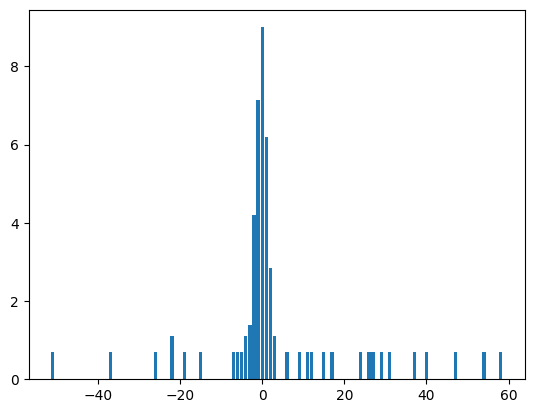

Z
[[ -5   1]
 [ -3   1]
 [ -2   2]
 [ -1  29]
 [  0 944]
 [  1  24]]


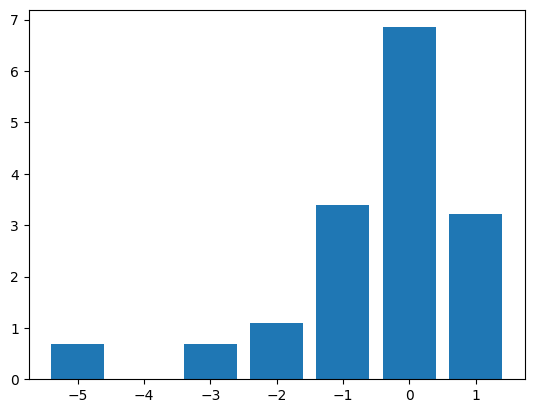

A
[[  -2    1]
 [  -1   25]
 [   0 4849]
 [   1  608]
 [   2   33]
 [  46    1]]


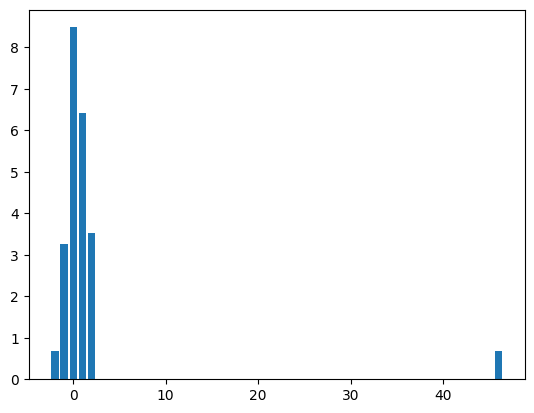

B
[[  -5    1]
 [  -2    4]
 [  -1   96]
 [   0 3410]
 [   1  104]
 [   2    3]
 [   3    1]]


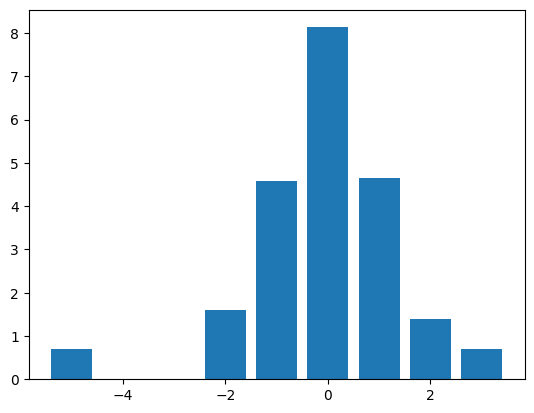

X_or_Y
[[  -2    2]
 [  -1  218]
 [   0 9780]
 [   1   82]
 [   2    1]]


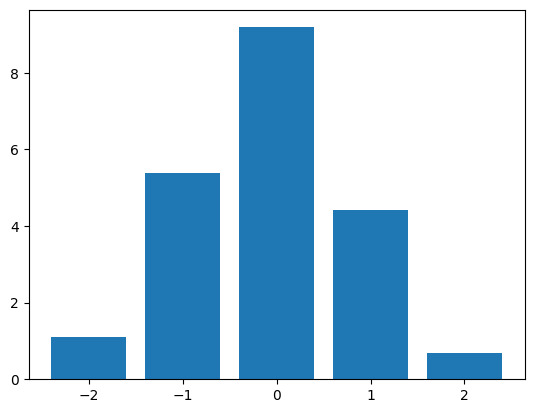

In [28]:
buttons = ['TRIGGER_LOGICAL', 'Z', 'A', 'B', 'X_or_Y']
results = []

for index, button in enumerate(buttons):
    button_is_pressed_once = (df[f'{button}_num_presses_target'] == 1) & (df[f'{button}_num_presses_pred'] == 1)
    
    
    # Filtering rows where the button was pressed exactly once in both target and prediction
    target_button_is_pressed_once = target[button_is_pressed_once, 4+index, :]
    pred_button_is_pressed_once = pred[button_is_pressed_once, 4+index, :]
    
    # Calculating indices for the first and last button press in the target and prediction for each example
    index_of_first_1_target = np.argmax(target_button_is_pressed_once > 0.5, axis=1)
    index_of_first_1_pred = np.argmax(pred_button_is_pressed_once > 0.5, axis=1)
    index_of_last_1_target = (target_button_is_pressed_once.shape[1] - np.argmax(target_button_is_pressed_once[:, ::-1] > 0.5, axis=1))
    index_of_last_1_pred = (pred_button_is_pressed_once.shape[1] - np.argmax(pred_button_is_pressed_once[:, ::-1] > 0.5, axis=1))

    length_of_target_press = index_of_last_1_target - index_of_first_1_target
    length_of_pred_press = index_of_last_1_pred - index_of_first_1_pred
    
    unique, count = np.unique(length_of_pred_press - length_of_target_press, return_counts=True)
    print(button)
    print(np.array([unique,count]).T)

    plt.bar(unique,np.log(count+1))
    plt.show()
    


Investigate the differece in the angle of the joystick and c-stick.h

In [37]:
target_angle_JSTICK = np.arctan2(target[:,0,:], target[:,1,:]) * 180 / np.pi
predicted_angle_JSTICK = np.arctan2(target[:,0,:], target[:,1,:]) * 180 / np.pi

print(target_angle_JSTICK)
# print(predicted_angle_JSTICK)

target_radius_JSTICK = np.sqrt(target[:,0,:] ** 2 + target[:,1,:] ** 2)

print(target_radius_JSTICK)


u


[[45.        45.        45.        ... 45.        45.        45.       ]
 [ 1.0050856  1.0050856  1.0050856 ...  1.0050856  1.0050856  1.0050856]
 [45.        45.        45.        ... 45.        45.        45.       ]
 ...
 [45.        45.        45.        ... 45.        45.        45.       ]
 [45.        45.        45.        ... 45.        45.        45.       ]
 [ 1.0050856  2.009553   3.0127897 ...  4.844002   4.685901   5.4403324]]
[[0.70710677 0.70710677 0.70710677 ... 0.70710677 0.70710677 0.70710677]
 [0.50007695 0.50007695 0.50007695 ... 0.50007695 0.50007695 0.50007695]
 [0.70710677 0.70710677 0.70710677 ... 0.70710677 0.70710677 0.70710677]
 ...
 [0.70710677 0.70710677 0.70710677 ... 0.70710677 0.70710677 0.70710677]
 [0.70710677 0.70710677 0.70710677 ... 0.70710677 0.70710677 0.70710677]
 [0.50007695 0.5003077  0.500692   ... 0.519399   0.5368822  0.55513227]]


In [56]:
target_no_transform = target[:, :4, :] - .5
target_no_transform[0:4, :] /= 1.40350877193 / 2
target_no_transform -= .2875 * (target_no_transform[:, 0:4, :] < 0)
target_no_transform += .2875 * (target_no_transform[:, 0:4, :] > 0)

 
predicted_no_transform = pred[:, :4, :] - .5
predicted_no_transform[0:4, :] /= 1.40350877193 / 2
predicted_no_transform -= .2875 * (predicted_no_transform[:, 0:4, :] < 0)
predicted_no_transform += .2875 * (predicted_no_transform[:, 0:4, :] > 0)

target_angle_JSTICK = np.arctan2(target_no_transform[:,0,:], target_no_transform[:,1,:]) * 180 / np.pi
predicted_angle_JSTICK = np.arctan2(predicted_no_transform[:,0,:], predicted_no_transform[:,1,:]) * 180 / np.pi

target_radius_JSTICK = np.sqrt(target_no_transform[:,0,:] ** 2 + target_no_transform[:,1,:] ** 2)
pred_radius_JSTICK = np.sqrt(predicted_no_transform[:,0,:] ** 2 + predicted_no_transform[:,1,:] ** 2)

# print(target_no_transform[:,0,:])
# # print(target_no_transform[:,1,:])
# print()

# print(predicted_no_transform[:,0,:])
# # print(predicted_no_transform[:,1,:])
# print()

print(target_angle_JSTICK)
print(predicted_angle_JSTICK)
print()

# print(target_radius_JSTICK)
# print(pred_radius_JSTICK)

[[  0.         0.         0.       ...   0.         0.         0.      ]
 [-90.       -90.       -90.       ... -90.       -90.       -90.      ]
 [  0.         0.         0.       ...   0.         0.         0.      ]
 ...
 [  0.         0.         0.       ...   0.         0.         0.      ]
 [  0.         0.         0.       ...   0.         0.         0.      ]
 [-90.       -90.       -90.       ... -67.696396 -66.54903  -65.163086]]
[[  46.75091    44.634445   43.041008 ...  134.63177    44.79178
    43.52984 ]
 [ -72.92611   -73.356094  -72.935234 ... -107.390396 -110.156105
  -123.9908  ]
 [ 128.86421  -135.56233   -44.74625  ... -132.60854  -133.23145
   -49.92035 ]
 ...
 [  43.728924   43.827778   42.189346 ...  134.67223    44.8963
    44.178852]
 [  44.631542  -44.552494 -134.91252  ...  134.1983    134.31468
  -134.28758 ]
 [ -65.21549   -65.757545  -65.0967   ...  -67.00291   -62.56648
   -59.472424]]

